# Optimisation - Unit Commitment
## Morgan Reilly (20235398), Shaurabh Kumar Singh (20231849)

In [1]:
# Imports
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [2]:
# Instantiate Solver
solver = pywraplp.Solver('Generator', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

<!-- Variables -->
$\underline{\textbf{Variables}}$
<br><br>
$A_{y} = $ Energy produced by Hydro Generator $A$ in $y^{th}$ hours<br>
$B_{y} = $ Energy produced by Hydro Generator $B$ in $y^{th}$ hours<br>
$C_{y} = $ Energy produced by Hydro Generator $C$ in $y^{th}$ hours<br>
$D_{y} = $ Energy produced by Hydro Generator $D$ in $y^{th}$ hours<br>
$E_{y} = $ Energy produced by Solid Generator $E$ in $y^{th}$ hours<br>
$F_{y} = $ Energy produced by Solid Generator $F$ in $y^{th}$ hours<br>
$G_{y} = $ Energy produced by Solid Generator $G$ in $y^{th}$ hours<br>
$H_{y} = $ Energy produced by Gas Generator $H$ in $y^{th}$ hours<br>
$I_{y} = $ Energy produced by Solar Generator $I$ in $y^{th}$ hours<br>
$J_{y} = $ Energy produced by Solar Generator $J$ in $y^{th}$ hours<br>

<!-- Constraints -->
$\underline{\textbf{Constraints}}$
<br><br>
$ \sum E_{i,j} = Demand_{j} $ 
<br><br>
&nbsp;&nbsp;&nbsp;&nbsp; $ where:$
* ${i} = A, B, C,..., J$ -> $Generators$
* ${j} = 1, 2, 3,..., 24$ -> $Hours$
* $E = Power$ $Generated$

<br>
$Non-Solar$ $Generators:$<br><br>&nbsp;&nbsp;&nbsp;&nbsp;
$Lower$ $Bound[i] \leqslant E_{i,j} \leqslant Upper$ $Bound[i]$
<br><br>
$Solar$ $Generators:$<br><br>&nbsp;&nbsp;&nbsp;&nbsp;
$Lower$ $Bound[i] \leqslant E_{i,j} \leqslant Upper$ $Bound[i]\times Solar$ $Curve[j]$

<!-- Objective Function -->
$\underline{\textbf{Objective Function}}$
<br><br>
$Minimise$&nbsp;$Cost:$ <br><br>&nbsp;&nbsp;&nbsp;&nbsp;
$ \sum_{i=A}^{J} (E_{i,j}\times C_{i})$&nbsp;&nbsp;&nbsp;$\forall$ &nbsp; ${[j = 1,...,24]} $

### Decision Variables
* In a small country there are 10 generators of four types: Hydroelectric, Solid fuel, Gas, Solar.
* Each generator has a lower and upper bound on its production per hour (in MW/h). Between these bounds, production is not limited to discrete levels. 
* Each generator also has a cost for producing each MW, and produces a certain amount of CO2 per MW.

In [3]:
#Ingest the Input
generators = pd.read_csv('generator_info.csv')
generators.head()

,name,type,lower_bound (MW),upper_bound (MW),cost/MW,CO2/MW
0,A,hydro,10,100,1.4,0.024
1,B,hydro,10,80,1.4,0.024
2,C,hydro,10,60,1.4,0.024
3,D,hydro,1,10,1.4,0.024
4,E,solid,100,900,4.4,0.820


In [4]:
generators.columns = ["name","type","lower_bound (MW)","upper_bound (MW)", "cost/MW", "CO2/MW"]
lower_bound = generators["lower_bound (MW)"].values.tolist()
upper_bound = generators["upper_bound (MW)"].values.tolist()
cost = generators["cost/MW"].values.tolist()
print("Lower Bounds: ", lower_bound)
print("Upper Bounds: ", upper_bound)
print("Costs: ", cost)

Lower Bounds:  [10, 10, 10, 1, 100, 100, 10, 100, 0, 0]
Upper Bounds:  [100, 80, 60, 10, 900, 600, 100, 400, 70, 20]
Costs:  [1.4, 1.4, 1.4, 1.4, 4.4, 4.4, 4.4, 9.1, 6.6, 6.6]


In [5]:
#Read the Demand.csv file
demand_df = pd.read_csv('demand.csv', header=None, names=['mw'])
demand_df.head()

,mw
0,1461
1,1446
2,1446
3,1438
4,1425


In [6]:
#Read the Solar Curve.csv file
solar_df = pd.read_csv('solar_curve.csv', header=None, names=['sw'])
solar_df.head()

,sw
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### Constraints
* The maximum supply from any Solar generator depends on the time of day. Relative to the generator’s maximum, it can achieve 50% from 6am to 10am, 100% from 11am to 3pm, 50% from 4pm to 6pm, and 0% otherwise.
* The Solid fuel generators cannot change their amount of production from one hour to the next.

In [7]:
#Create Continous variables for each generator and each hour in a day with their lower and upper bounds
A = [solver.NumVar(lower_bound[0], upper_bound[0], f'A{i}') for i in range(0,24)]
B = [solver.NumVar(lower_bound[1], upper_bound[1], f'B{i}') for i in range(0,24)]
C = [solver.NumVar(lower_bound[2], upper_bound[2], f'C{i}') for i in range(0,24)]
D = [solver.NumVar(lower_bound[3], upper_bound[3], f'D{i}') for i in range(0,24)]
E = solver.NumVar(lower_bound[4], upper_bound[4], "E")
F = solver.NumVar(lower_bound[5], upper_bound[5], "F")
G = solver.NumVar(lower_bound[6], upper_bound[6], "G")
H = [solver.NumVar(lower_bound[7], upper_bound[7], f'H{i}') for i in range(0,24)]
I = [solver.NumVar(lower_bound[8], upper_bound[8]*solar_df['sw'][i], f'I{i}') for i in range(0,24)]
J = [solver.NumVar(lower_bound[9], upper_bound[9]*solar_df['sw'][i], f'J{i}') for i in range(0,24)]

In [8]:
#Creating Contraints
#1. Energy generated per hour is equal to the per hour demand
for i in range(0, 24):
    solver.Add(A[i] + B[i] + C[i] + D[i] + E + F + G + H[i] + I[i] + J[i] == demand_df['mw'][i]) #for each hour
    
#print(solver.NumConstraints())

### Formaising Objective
* Goal is to meet demand at each hour at the minimum cost, by choosing how much energy each generator should produce per hour
* The demand from electricity customers varies by hour of the day. This is given in demand.csv. If we over-supply relative to demand, it can damage the electricity infrastructure. If we under-supply, then some customers can’t boil their kettles.

In [9]:
#Objective
objective = solver.Objective()

# Time specific values
for i in range(0, 24):
    objective.SetCoefficient(A[i],cost[0])
    objective.SetCoefficient(B[i],cost[1])
    objective.SetCoefficient(C[i],cost[2])
    objective.SetCoefficient(D[i],cost[3])
    objective.SetCoefficient(H[i],cost[7])
    objective.SetCoefficient(I[i],cost[8])
    objective.SetCoefficient(J[i],cost[9])

# Solid generator values -> 24 hours
objective.SetCoefficient(E, cost[4] * 24)
objective.SetCoefficient(F, cost[5] * 24)
objective.SetCoefficient(G, cost[6] * 24)

objective.SetMinimization()  # Minimise Objective Function

### Solve

In [10]:
# Solve the system.
result = solver.Solve()
if result == solver.OPTIMAL:
    for v in solver.variables():
        print(f"{v.name()} = {v.solution_value():.1f}")
    print(f"z = {objective.Value():.1f}")
else:
    print("Problem is not feasible")

A0 = 69.0
A1 = 54.0
A2 = 54.0
A3 = 46.0
A4 = 33.0
A5 = 28.0
A6 = 75.0
A7 = 100.0
A8 = 100.0
A9 = 100.0
A10 = 100.0
A11 = 100.0
A12 = 100.0
A13 = 100.0
A14 = 100.0
A15 = 100.0
A16 = 100.0
A17 = 100.0
A18 = 100.0
A19 = 100.0
A20 = 100.0
A21 = 100.0
A22 = 87.0
A23 = 71.0
B0 = 80.0
B1 = 80.0
B2 = 80.0
B3 = 80.0
B4 = 80.0
B5 = 80.0
B6 = 80.0
B7 = 80.0
B8 = 80.0
B9 = 80.0
B10 = 80.0
B11 = 80.0
B12 = 80.0
B13 = 80.0
B14 = 80.0
B15 = 80.0
B16 = 80.0
B17 = 80.0
B18 = 80.0
B19 = 80.0
B20 = 80.0
B21 = 80.0
B22 = 80.0
B23 = 80.0
C0 = 60.0
C1 = 60.0
C2 = 60.0
C3 = 60.0
C4 = 60.0
C5 = 60.0
C6 = 60.0
C7 = 60.0
C8 = 60.0
C9 = 60.0
C10 = 60.0
C11 = 60.0
C12 = 60.0
C13 = 60.0
C14 = 60.0
C15 = 60.0
C16 = 60.0
C17 = 60.0
C18 = 60.0
C19 = 60.0
C20 = 60.0
C21 = 60.0
C22 = 60.0
C23 = 60.0
D0 = 10.0
D1 = 10.0
D2 = 10.0
D3 = 10.0
D4 = 10.0
D5 = 10.0
D6 = 10.0
D7 = 10.0
D8 = 10.0
D9 = 10.0
D10 = 10.0
D11 = 10.0
D12 = 10.0
D13 = 10.0
D14 = 10.0
D15 = 10.0
D16 = 10.0
D17 = 10.0
D18 = 10.0
D19 = 10.0
D20 = 10.0
D2

### Visualisation

In [11]:
#Create list of Solution Variable
sol_var = []
for v in solver.variables(): sol_var.append(v.solution_value())

# Set Generator lists
A_list, B_list, C_list, D_list, E_list, F_list, G_list, H_list, I_list, J_list = [], [], [], [], [], [], [], [], [], []
# Generator lists of power generator per generator
for i in range (0, 24): A_list.append(A[i].solution_value())
for i in range (0, 24): B_list.append(B[i].solution_value())
for i in range (0, 24): C_list.append(C[i].solution_value())
for i in range (0, 24): D_list.append(D[i].solution_value())    
for i in range (0, 24): E_list.append(E.solution_value())
for i in range (0, 24): F_list.append(F.solution_value())
for i in range (0, 24): G_list.append(G.solution_value())
for i in range (0, 24): H_list.append(H[i].solution_value())
for i in range (0, 24): I_list.append(I[i].solution_value())
for i in range (0, 24): J_list.append(J[i].solution_value())

hours = []
for i in range(1, 25): hours.append(i)

<function matplotlib.pyplot.show(close=None, block=None)>

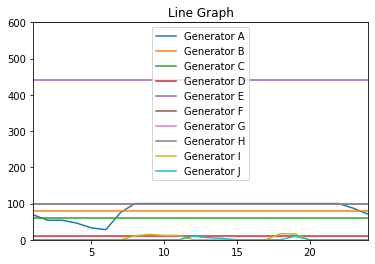

In [14]:
# Visualisation
plt.plot(hours, A_list, label='Generator A')
plt.plot(hours, B_list, label='Generator B')
plt.plot(hours, C_list, label='Generator C')
plt.plot(hours, D_list, label='Generator D')
plt.plot(hours, E_list, label='Generator E')
plt.plot(hours, F_list, label='Generator F')
plt.plot(hours, G_list, label='Generator G')
plt.plot(hours, G_list, label='Generator H')
plt.plot(hours, I_list, label='Generator I')
plt.plot(hours, J_list, label='Generator J')
plt.legend()
plt.title("Line Graph")
plt.margins(0)
plt.show

![Overall Generation](./img/PowerGeneration.png)

![Overall Contribution](./img/OveralContribution.png)

### Interpretation

* From our findings we see that by minimizing the cost the best objective value is 151518.00. This is using all generators from across 24 hours of the day. However if we only use 12 hours of production the objective function changes to 132649.80, resulting in a difference of: 18868.20
* If we change the opitmisation function from minimum to maximum, and use all generators, then we see that the objective value changes from 151518.00 to 469518.00, resulting in a difference of: 318000.00
* If we remove certain generators we see that the objective value also changes with respect to the minimum function.
    * Removal of Hydro generators results in a change to the minimum to 143654.20, which is a difference of 7863.80
    * Removal of Solid generators results in the a change to the minimum to 24995.6, which is a difference of 126522.40 
    * Removal of Gas generators results in a change to the minimum to 98815.20, which is a difference of 52702.80
    * Removal of Solar generators results in a change to the minimum to 148552.30, which is a difference of 2965.70
    
    From these results we can interperate that the Gas and Solid generators have quite a high impact on the minimum, and we can safely assume the same if the objective function was to maximise. We can also infer from this that the two most utilised generators were Solid and Gas

## References
* [Optimisation with OR Tools - Accessed: 26/10/2020 at 14:37](https://www.kaggle.com/nicapotato/optimisation-101-with-or-tools)
* [OR Tools Documentation - Accessed: 27/10/2020 at 19:51](https://developers.google.com/optimization/introduction/python)
* [Solver Contraint Documentation - Accessed: 29/10/2020 at 18:22](https://github.com/google/or-tools/blob/v8.0/ortools/constraint_solver/constraint_solver.h#L3556)